In [1]:
import numpy as np

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from infomercial.exp import meta_bandit
from infomercial.exp import epsilon_bandit
from infomercial.local_gym import bandit
from infomercial.exp.meta_bandit import load_checkpoint
import gym

from pprint import pprint

def plot_meta(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_E = result["scores_E"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    values_E = result["values_E"]
    ties = result["ties"]
    policies = result["policies"]
    
    # -
    env = gym.make(env_name)
    best = env.env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best, np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # Policy
    policies = np.asarray(policies)
    episodes = np.asarray(episodes)
    plt.subplot(grid[1, 0])
    m = policies == 0
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_E$", color="purple")
    m = policies == 1
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_R$", color="grey")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Controlling\npolicy")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()
    
    # score
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, scores_E, color="purple", alpha=0.4, s=2, label="E")
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
    plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, values_E, color="purple", alpha=0.4, s=2, label="$Q_E$")
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Episode")
    plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Ties
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Ties
    plt.subplot(grid[5, 0])
    plt.scatter(episodes, ties, color="black", alpha=.5, s=2, label="Tie : 1\n $\pi_\pi$ : 0")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Ties index")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
def plot_epsilon(env_name, result):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    epsilons = result["epsilons"]
    
    # -
    env = gym.make(env_name)
    best = env.env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best, np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Decay
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, epsilons, color="black", alpha=.5, s=2)
    plt.ylabel("$\epsilon_R$")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [2]:
pprint(
    [d for d in dir(bandit) if d not in (
    '__builtins__','__cached__',
    '__doc__',
    '__file__',
    '__loader__',
    '__name__',
    '__package__',
    '__spec__',
    'gym',
    'np',
    'seeding',
    'spaces',
    'warnings')]
)

['BanditEnv',
 'BanditEvenOdds2',
 'BanditGaussian10',
 'BanditHardAndSparse10',
 'BanditHardAndSparse1000',
 'BanditHardAndSparse121',
 'BanditHardAndSparse2',
 'BanditOneHigh10',
 'BanditOneHigh1000',
 'BanditOneHigh121',
 'BanditOneHigh2',
 'BanditOneHot10',
 'BanditOneHot1000',
 'BanditOneHot121',
 'BanditOneHot2',
 'BanditTwoExtreme1000',
 'BanditTwoHigh1000',
 'BanditTwoHigh121',
 'UnstableBanditEnv']


# TwoHigh

Best arm: 0, last arm: 0


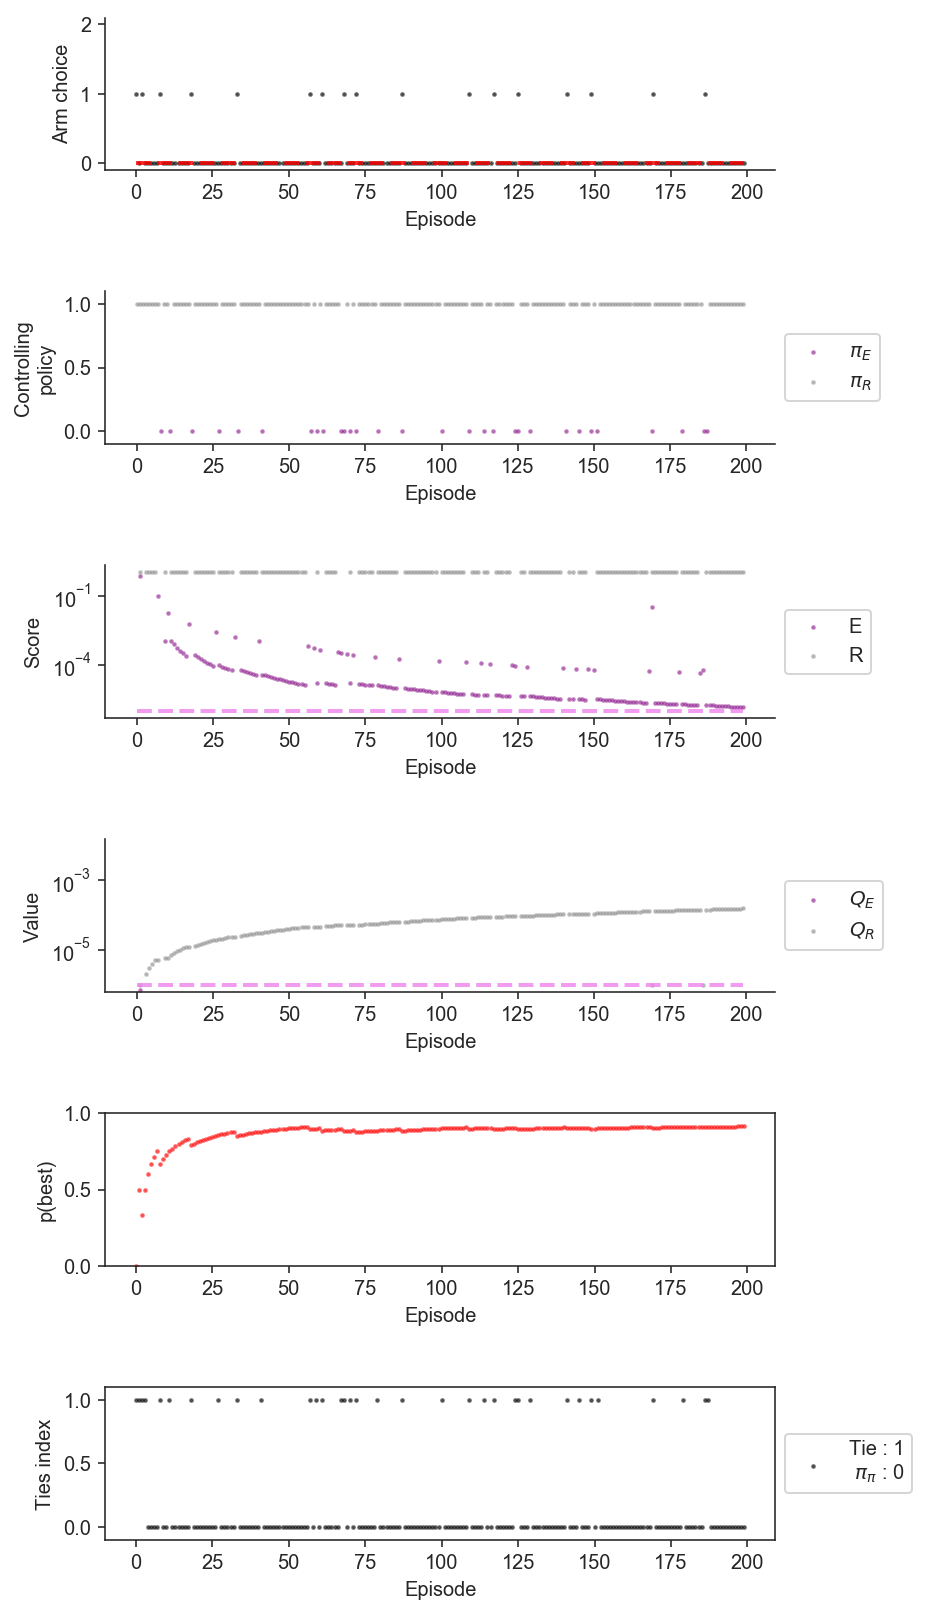

In [11]:
env_name = 'BanditOneHigh2-v0'
n_arm = 2
tie_break = 'next' # round robin tie break strategy
tie_threshold = 0.000001  # epsilon in the paper
lr = .001

# Run bandit exps
result_meta = meta_bandit(
    env_name=env_name,
    num_episodes=n_arm*50, 
    lr=lr, 
    tie_threshold=tie_threshold, 
    tie_break=tie_break,
    seed_value=179,
)

plot_meta(env_name, result_meta)

In [ ]:
env_name = 'BanditOneHigh2-v0'

# Run bandit exps
result_ep = epsilon_bandit(
    env_name=env_name,
    num_episodes=n_arm*100, 
    lr=lr, 
    epsilon=0.2,
    epsilon_decay_tau=0.0,
    seed_value=179,
)

plot_epsilon(env_name, result_ep)

In [ ]:
env_name = 'BanditOneHigh2-v0'

# Run bandit exps
result_decay = epsilon_bandit(
    env_name=env_name,
    num_episodes=n_arm*100, 
    lr=lr, 
    epsilon=0.2,
    epsilon_decay_tau=0.04,
    seed_value=179,
)

plot_epsilon(env_name, result_decay)

# OneHigh121

Best arm: 54, last arm: 19


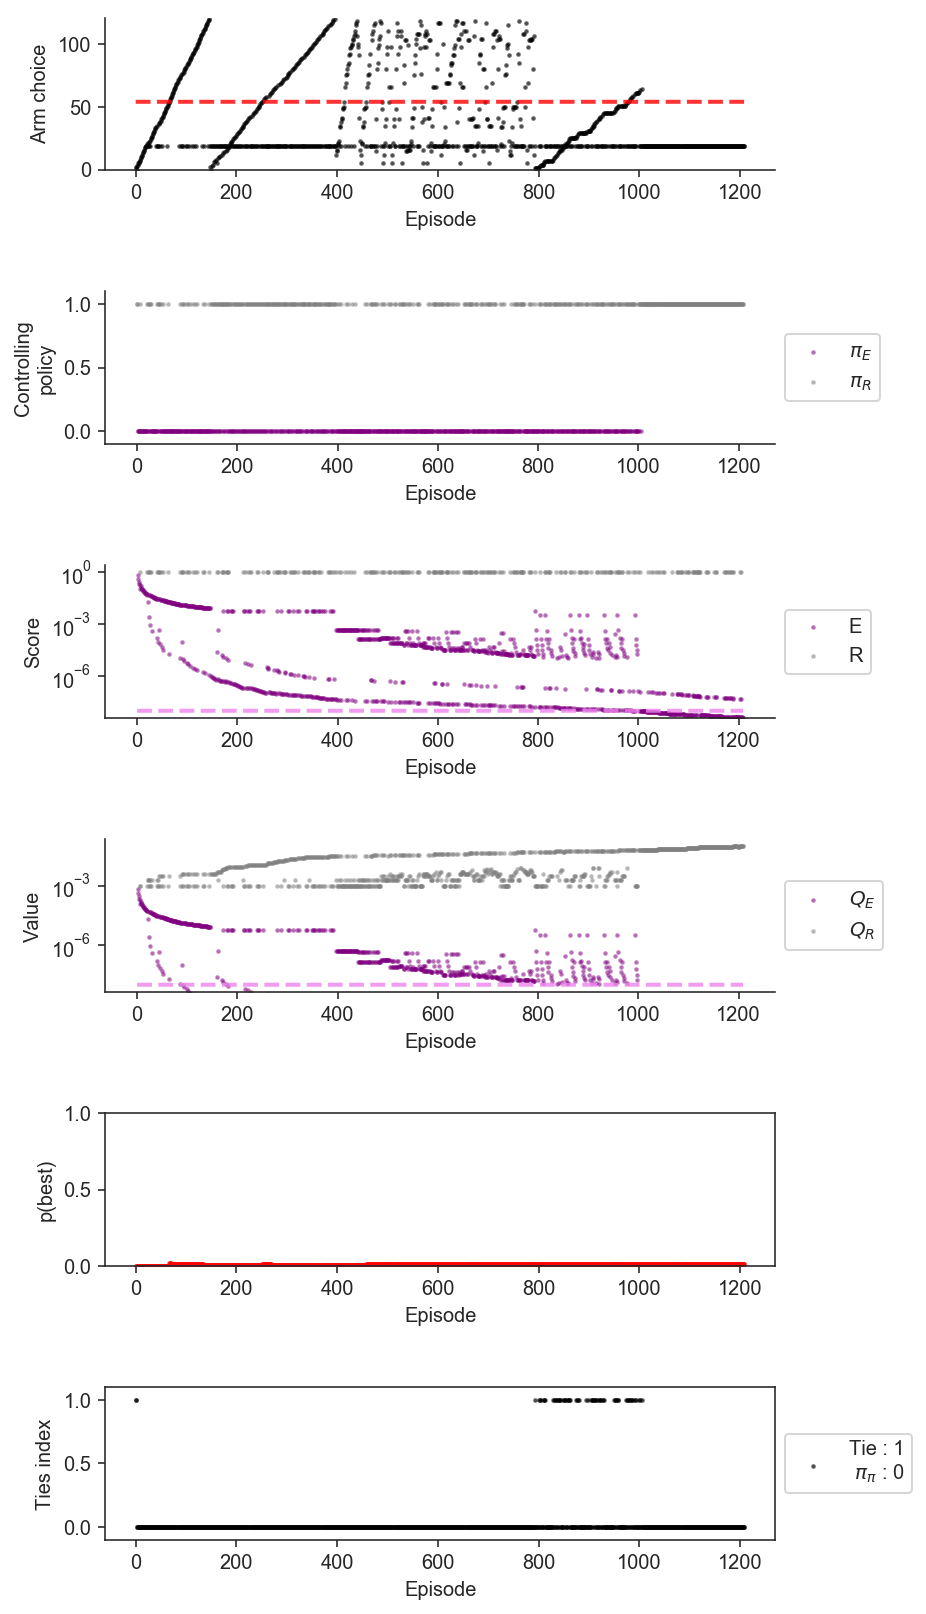

In [14]:
env_name = 'BanditOneHigh121-v0'
n_arm = 121
tie_break = 'next' # round robin tie break strategy
tie_threshold = 1*0.001  # epsilon in the paper
lr = .00001

# Run bandit exps
result_meta = meta_bandit(
    env_name=env_name,
    num_episodes=n_arm*10, 
    lr=lr, 
    tie_threshold=tie_threshold, 
    tie_break=tie_break,
    seed_value=179,
)

plot_meta(env_name, result_meta)

In [ ]:
env_name = 'BanditOneHigh121-v0'

# Run bandit exps
result_decay = epsilon_bandit(
    env_name=env_name,
    num_episodes=n_arm*5, 
    lr=lr, 
    epsilon=0.5,
    epsilon_decay_tau=0.04,
    seed_value=179,
)

plot_epsilon(env_name, result_decay)

# TwoHardAndSparse

In [ ]:
env_name = 'BanditHardAndSparse2-v0'
n_arm = 2
tie_break = 'next' # round robin tie break strategy
tie_threshold = 0.0000001  # epsilon in the paper
lr = .015

# Run bandit exps
result_meta = meta_bandit(
    env_name=env_name,
    num_episodes=n_arm*1000, 
    lr=lr, 
    tie_threshold=tie_threshold, 
    tie_break=tie_break,
    seed_value=179,
)

plot_meta(env_name, result_meta)

In [ ]:
# Run bandit exps
result_decay = epsilon_bandit(
    env_name=env_name,
    num_episodes=n_arm*1000, 
    lr=lr, 
    epsilon=0.5,
    epsilon_decay_tau=0.001,
    seed_value=179,
)

plot_epsilon(env_name, result_decay)